In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from functools import partial
from collections import namedtuple, defaultdict

# Algorithms

In [752]:
def norm(x, start_idx=0):
    if start_idx < 0:
        start_idx = x.ndim + start_idx
    return (x**2).sum(axis=tuple(range(start_idx, x.ndim)))**0.5

In [698]:
def adaprox(x0, df, proj, n, ergodic=True, **_):
    delta_squared_sum = 0
    eta_sum = 0
    weighted_x_t05_sum = 0

    eta_t = 1
    x_t = x0

    yield x0
    for _ in range(n):
        # t+1/2
        v_t = df(x_t)
        x_t05 = proj(x_t, -eta_t*v_t)

        # t+1
        v_t05 = df(x_t05)
        x_t = proj(x_t, -eta_t*v_t05)

        # ergodic average
        eta_sum += eta_t
        weighted_x_t05_sum += eta_t * x_t05

        if ergodic:
            yield weighted_x_t05_sum / eta_sum
        else:
            yield x_t05

        # adaptive step size
        d_t = norm(v_t05 - v_t)
        delta_squared_sum += d_t**2
        eta_t = 1 / np.sqrt(1 + delta_squared_sum)


In [699]:
def extragradient(x0, df, proj, n, eta=1, ergodic=True, **_):
    eta_sum = 0
    weighted_x_t05_sum = 0

    x_t = x0

    yield x0
    for i in range(n):
        # t+1/2
        x_t05 = proj(x_t, -eta*df(x_t))

        # t+1
        x_t = proj(x_t, -eta*df(x_t05))

        # ergodic average
        eta_sum += eta
        weighted_x_t05_sum += eta * x_t05

        if ergodic:
            yield weighted_x_t05_sum / eta_sum
        else:
            yield x_t05

In [700]:
def universal_mirror_prox(x0, df, proj, n, ergodic=True, **_):
    D = np.sqrt(2)
    G0 = 2

    x_t_sum = 0
    Z_t_sum = 0

    y_t = x0
    yield x0
    for i in range(n):
        y_t_prev = y_t
        eta_t = D / np.sqrt(G0 + Z_t_sum)

        Mt = df(y_t)

        x_t = proj(y_t_prev, -eta_t*Mt)

        gt = df(x_t)

        y_t = proj(y_t_prev, -eta_t*gt)

        Z_t = (norm(x_t - y_t)**2 + norm(x_t - y_t_prev)**2) / (5*eta_t**2)
        Z_t_sum += Z_t
        x_t_sum += x_t

        if ergodic:
            yield 1/(i+1) * x_t_sum
        else:
            yield x_t

In [888]:
Algo = namedtuple('Algo', ['name', 'fct'])

algos = [
    Algo('Universal Mirror-Prox', universal_mirror_prox),
    Algo('Extra-Gradient', extragradient),
    Algo('Adaptive Proximal Gradient', adaprox),
]

class Problem:
    def __init__(self, fx, dfx, proj, opt=None, dim=(2,)):
        self.fx = fx
        self.dfx = dfx
        self.proj = proj
        self.dim = dim
        self.opt = opt

        self.plot_by_metric = {
            'opt_dist': ('distance to optimum', self._plot_trials_opt_dist),
            'grad_norm': ('gradient norm', self._plot_trials_grad_norm),
        }

    def _plot_trials_opt_dist(self, algo_trials, label, ax=None):
        if self.opt is None:
            print('No optimum provided, skipping distance to optimum plot')
            return
        if ax is None:
            ax = plt.gca()
        dist = norm(algo_trials - self.opt, start_idx=-len(self.dim))
        n = dist.shape[-1]
        dist_mean = np.mean(dist, axis=0)
        dist_std = np.std(dist, axis=0)
        ax.plot(dist_mean, label=label)
        ax.fill_between(range(n), dist_mean - dist_std, dist_mean + dist_std, alpha=.2)

    def _plot_trials_grad_norm(self, algo_trials, label, ax=None):
        if ax is None:
            ax = plt.gca()
        grad = self.dfx(algo_trials)
        grad_norm = norm(grad, start_idx=-len(self.dim))
        n = grad_norm.shape[-1]
        grad_norm_mean = np.mean(grad_norm, axis=0)
        grad_norm_std = np.std(grad_norm, axis=0)
        ax.plot(grad_norm_mean, label=label)
        ax.fill_between(range(n), grad_norm_mean - grad_norm_std, grad_norm_mean + grad_norm_std, alpha=.2)

    def plot_trials(self, trials, metric, title='', ax=None, show_legend=False, show_metric_title=True):
        assert metric in self.plot_by_metric, f'Unknown metric {metric} (choose from {list(self.plot_by_metric.keys())})'
        if ax is None:
            ax = plt.gca()
        metric_title, plot_metric = self.plot_by_metric[metric]
        for algo, algo_trials in trials.items():
            algo_trials = np.array(algo_trials) # (n_trials, n, *dim)
            plot_metric(algo_trials, algo, ax=ax)
        if show_legend:
            ax.legend(loc='center left', bbox_to_anchor=(1.01, .5))
        if show_metric_title:
            ax.set_ylabel(metric_title)
        ax.set_title(title)
        ax.set_xlabel('iteration')
        ax.set_yscale('log')

    def run_trials(self, n, n_trials=10, seed=None, init_space=[-1, 1], **extra_args):
        if seed is not None:
            np.random.seed(seed)
        trials = defaultdict(list)
        for _ in trange(n_trials, desc=f'trials ({extra_args})'):
            x0 = np.random.uniform(*init_space, size=self.dim)
            x0 = self.proj(x0, 0)
            for algo in algos:
                xs = np.stack(list(algo.fct(x0, self.dfx, self.proj, n, **extra_args)), axis=0)
                trials[algo.name].append(xs)
        return trials

# Basic Min-Max Problem

$$
\begin{align}
\min_{\theta \in [-1, 1]} \max_{\phi \in [-1, 1]} \theta \phi
\end{align}
$$

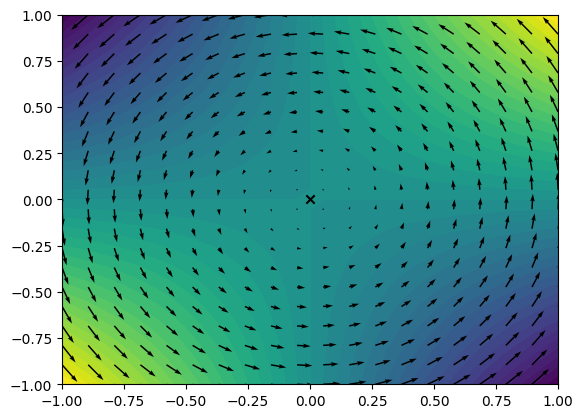

In [889]:
def fx(x): return x[..., 0] * x[..., 1]
def dfx(x): return np.stack([-x[..., 1], x[..., 0]], axis=-1)
def proj(x, grad): return np.clip(x + grad, -1, 1)
opt = np.array([0, 0])

default_run_args = {
    'n': 200,
    'seed': 42,
    'eta': .9,
}

pb = Problem(fx, dfx, proj, opt)

def plot_fx(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    space = np.linspace(-1, 1, 20)
    X1, X2 = np.meshgrid(space, space)
    Y = fx(np.stack([X1, X2], axis=-1))
    x = np.stack([X1.flatten(), X2.flatten()], axis=-1)

    ax.contourf(X1, X2, Y, 40)
    ax.quiver(x[:,0], x[:,1], *dfx(x).T, color='k')
    ax.scatter(*opt, marker='x', color='k')

plot_fx()

trials ({'ergodic': False, 'eta': 0.9}): 100%|██████████| 1/1 [00:00<00:00, 50.34it/s]


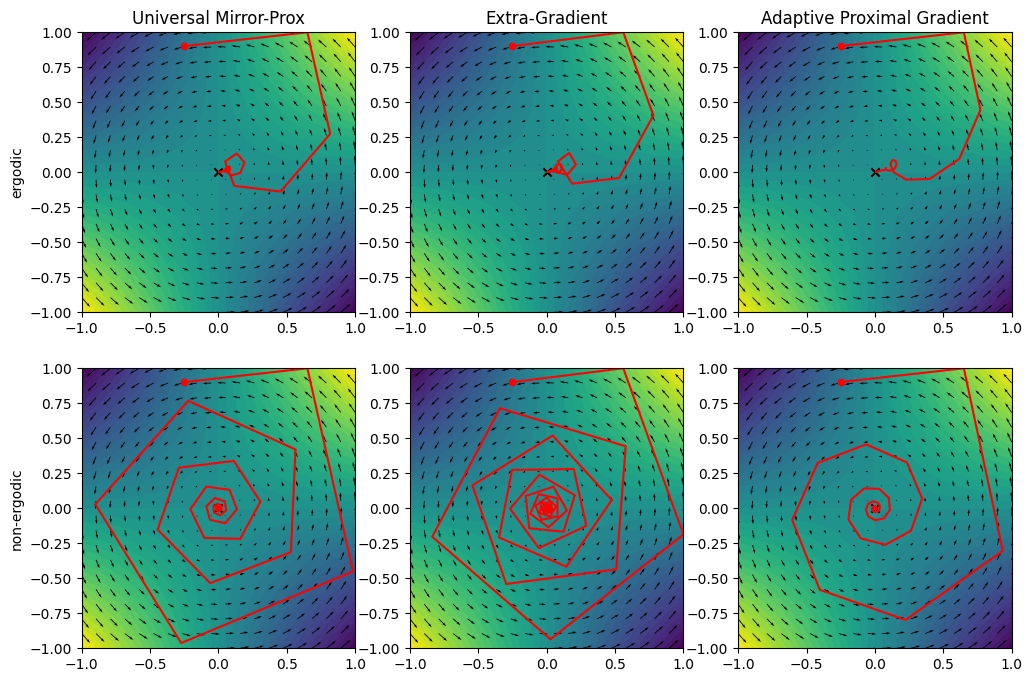

In [890]:
n_plots = len(algos)
_, axs = plt.subplots(2, n_plots, figsize=(4*n_plots, 4*2))

for i, ergodic in enumerate([True, False]):
    trials_by_algo = pb.run_trials(n_trials=1, ergodic=ergodic, **default_run_args)

    axs[i, 0].set_ylabel('ergodic' if ergodic else 'non-ergodic')
    for j, (algo, trials) in enumerate(trials_by_algo.items()):
        trial = trials[0]
        plot_fx(ax=axs[i, j])
        axs[i,j].plot(trial[:,0], trial[:,1], '-', color='r')
        axs[i,j].scatter(*trial[0], color='r', s=20)
        if i == 0:
            axs[i,j].set_title(algo)


trials ({'ergodic': True, 'eta': 0.9}): 100%|██████████| 20/20 [00:00<00:00, 56.54it/s]


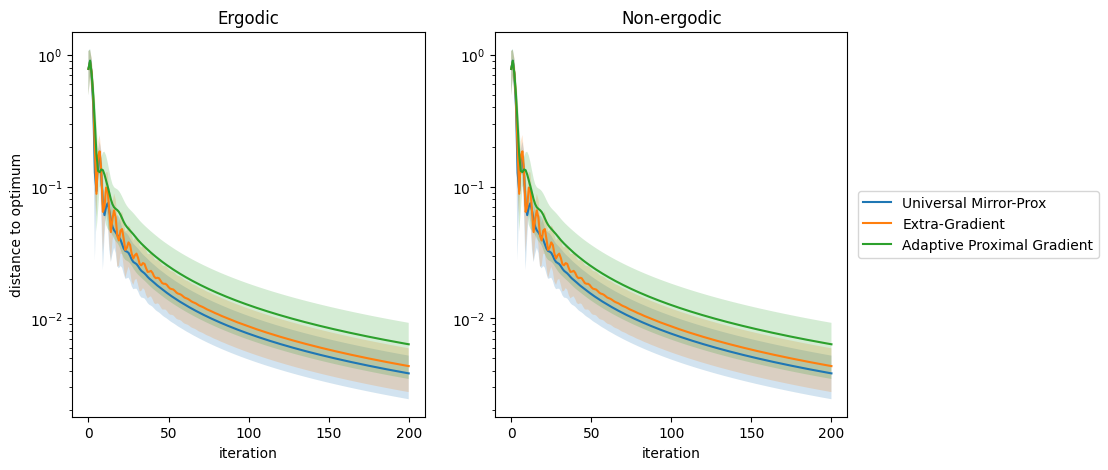

In [891]:
n = 200
n_trials = 20

_, axs = plt.subplots(1, 2, figsize=(2*5, 5))

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=True, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Ergodic', ax=axs[0])

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=True, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Non-ergodic', ax=axs[1], show_legend=True, show_metric_title=False)

# Basic Min-Max Problem (using example 5.2)

$$
\begin{align}
\min_{\theta \in [0, 1]} \max_{\phi \in [0, 1]} (\theta - 1/2) (\phi - 1/2)
\end{align}
$$

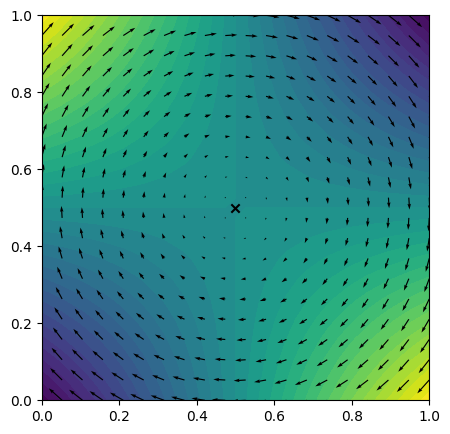

In [892]:
# mu = np.array([1/2, 1/4])

# def fx(x): return (1/(mu - x)).sum(axis=-1)
# def dfx(x): return np.stack([-(mu[...,0] - x[...,0])**-2, -(mu[...,1] - x[...,1])**-2], axis=-1)
# def proj(x, grad): return np.clip(x*1/(1 - grad*x**2)**.5, 1e-6, 1)


def fx(x): return -(x[..., 0] - 1/2) * (x[..., 1] - 1/2)
def dfx(x): return np.stack([x[..., 1] - 1/2, -x[..., 0] + 1/2], axis=-1)
def proj(x, grad): return np.clip(x*1/(1 - grad*x**2)**.5, 0, 1)

opt = np.array([1/2, 1/2])

default_run_args = {
    'n': 200,
    'init_space': [0, 1],
    'seed': 42,
    'eta': .9,
}

pb = Problem(fx, dfx, proj, opt)

def plot_fx(ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    space = np.linspace(0, 1, 20)
    X1, X2 = np.meshgrid(space, space)
    Y = fx(np.stack([X1, X2], axis=-1))
    x = np.stack([X1.flatten(), X2.flatten()], axis=-1)

    ax.contourf(X1, X2, Y, 40)
    ax.quiver(x[:,0], x[:,1], *dfx(x).T, color='k')
    ax.scatter(*opt, marker='x', color='k')

plot_fx()

trials ({'ergodic': False, 'eta': 0.9}): 100%|██████████| 1/1 [00:00<00:00, 44.65it/s]


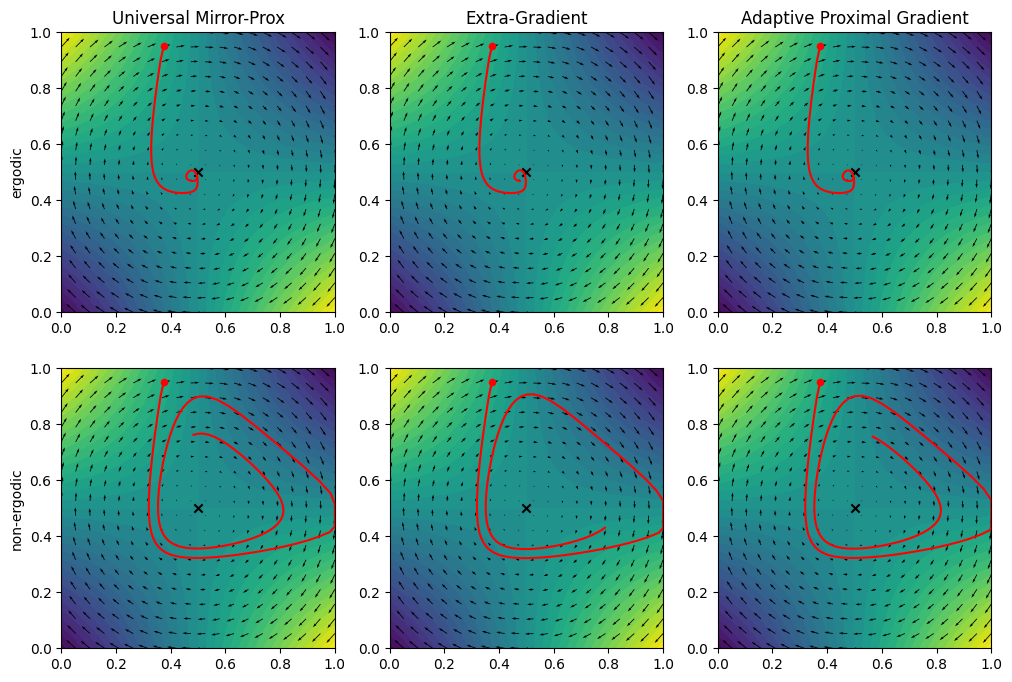

In [893]:
n_plots = len(algos)
_, axs = plt.subplots(2, n_plots, figsize=(4*n_plots, 4*2))

for i, ergodic in enumerate([True, False]):
    trials_by_algo = pb.run_trials(n_trials=1, ergodic=ergodic,
    **default_run_args)

    axs[i, 0].set_ylabel('ergodic' if ergodic else 'non-ergodic')
    for j, (algo, trials) in enumerate(trials_by_algo.items()):
        trial = trials[0]
        plot_fx(ax=axs[i, j])
        axs[i,j].plot(trial[:,0], trial[:,1], '-', color='r')
        axs[i,j].scatter(*trial[0], color='r', s=20)
        if i == 0:
            axs[i,j].set_title(algo)


trials ({'ergodic': False, 'eta': 0.9}): 100%|██████████| 50/50 [00:01<00:00, 45.95it/s]


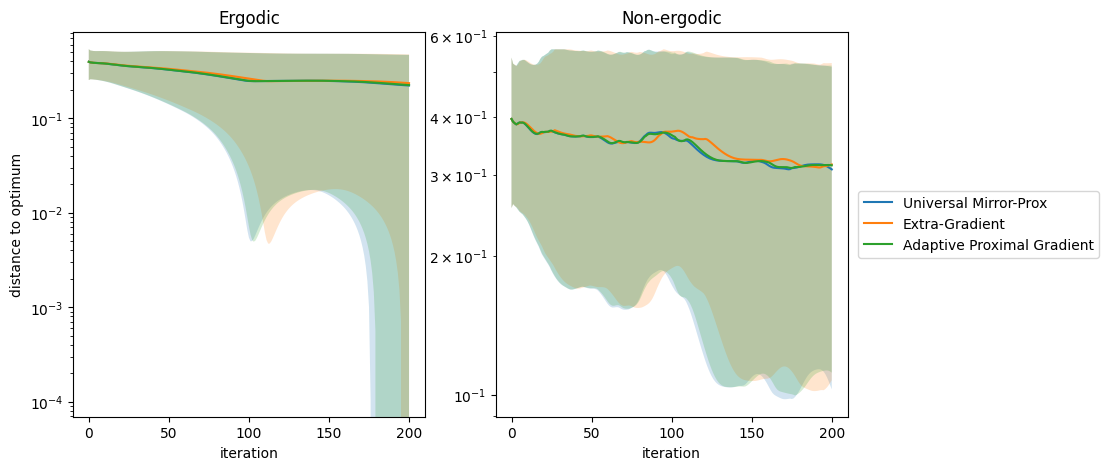

In [894]:
n_trials = 50

_, axs = plt.subplots(1, 2, figsize=(2*5, 5))

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=True, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Ergodic', ax=axs[0])

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=False, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Non-ergodic', ax=axs[1], show_legend=True, show_metric_title=False)

# 1D Min-Max Problem

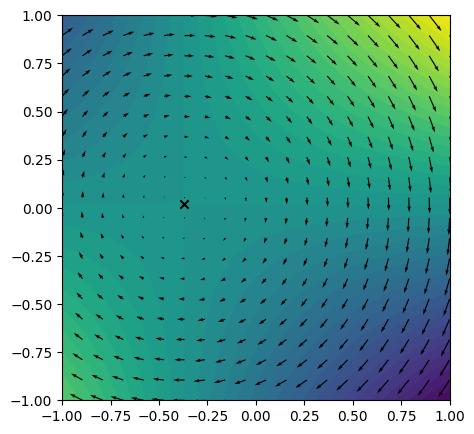

In [895]:
bound = 1

a = np.random.randn()
p1_opt = np.random.uniform(-bound, bound)
p2_opt = np.random.uniform(-bound, bound)
opt = np.array([p1_opt, p2_opt])

def fx(x): return (x[...,0]-p1_opt) * a * (x[...,1]-p2_opt).T
def dfx(x): return np.stack([(x[...,1]-p2_opt) * a, -(x[...,0]-p1_opt) * a], axis=-1)
def proj(x, grad): return np.clip(x + grad, -bound, bound)


default_run_args = {
    'n': 200,
    'init_space': [-bound, bound],
    'seed': 42,
    'eta': .1,
}

pb = Problem(fx, dfx, proj, opt)

def plot_fx(ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    space = np.linspace(*default_run_args['init_space'], 20)
    X1, X2 = np.meshgrid(space, space)
    X = np.stack([X1, X2], axis=-1)
    Y = fx(X.reshape(-1, 2)).reshape(X1.shape)
    x = np.stack([X1.flatten(), X2.flatten()], axis=-1)

    c = ax.contourf(X1, X2, Y, 40)
    ax.quiver(x[:,0], x[:,1], *dfx(x).T, color='k')
    ax.scatter(*opt, marker='x', color='k')

plot_fx()

trials ({'ergodic': False, 'eta': 0.1}): 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]


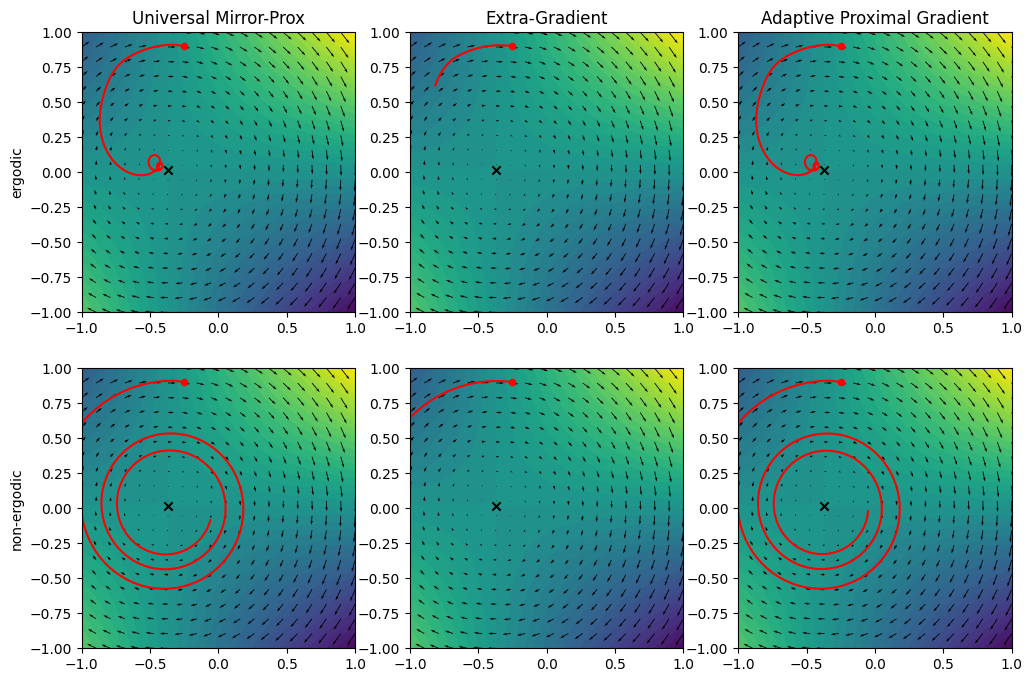

In [896]:
n_plots = len(algos)
_, axs = plt.subplots(2, n_plots, figsize=(4*n_plots, 4*2))

for i, ergodic in enumerate([True, False]):
    trials_by_algo = pb.run_trials(n_trials=1, ergodic=ergodic,
    **default_run_args)

    axs[i, 0].set_ylabel('ergodic' if ergodic else 'non-ergodic')
    for j, (algo, trials) in enumerate(trials_by_algo.items()):
        trial = trials[0]
        plot_fx(ax=axs[i, j])
        axs[i,j].plot(trial[:,0], trial[:,1], '-', color='r')
        axs[i,j].scatter(*trial[0], color='r', s=20)
        if i == 0:
            axs[i,j].set_title(algo)

trials ({'ergodic': False, 'eta': 0.1}): 100%|██████████| 50/50 [00:00<00:00, 52.65it/s]


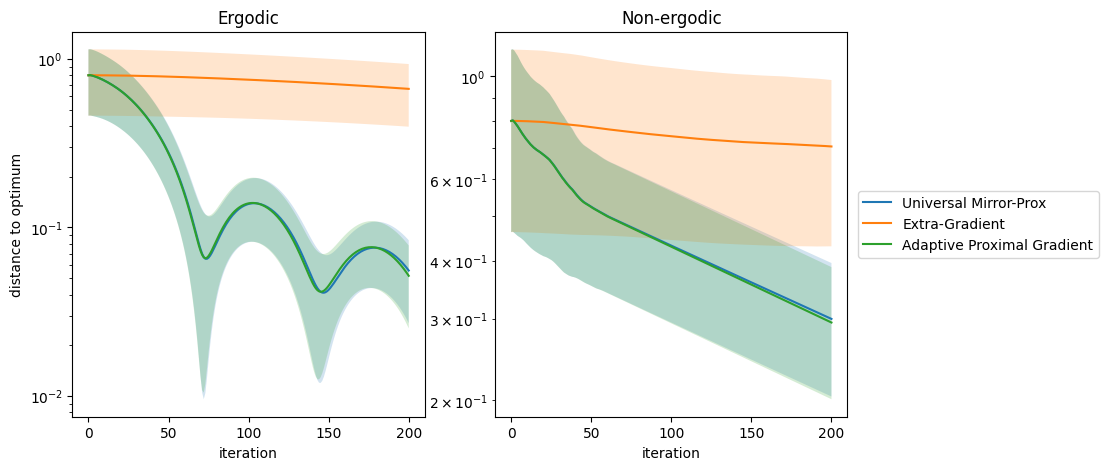

In [897]:
n_trials = 50

_, axs = plt.subplots(1, 2, figsize=(2*5, 5))

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=True, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Ergodic', ax=axs[0])

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=False, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Non-ergodic', ax=axs[1], show_legend=True, show_metric_title=False)

# 100D Min-Max Problem

In [898]:
bound = 1
dim = 100

A = np.random.randn(dim, dim)
p1_opt = np.random.uniform(-bound, bound, size=dim)
p2_opt = np.random.uniform(-bound, bound, size=dim)
opt = np.array([p1_opt, p2_opt])

def fx(x): return (x[0,:]-p1_opt) @ A @ (x[1,:]-p2_opt).T
def dfx(x): return np.stack([(x[...,1,:]-p2_opt) @ A.T, (x[...,0,:]-p1_opt) @ A], axis=0)
def proj(x, grad): return np.clip(x + grad, -bound, bound)

default_run_args = {
    'n': 200,
    'init_space': [-bound, bound],
    'seed': 42,
    'eta': .1,
}

pb = Problem(fx, dfx, proj, opt, dim=(2, dim))

trials ({'ergodic': False, 'eta': 0.1}): 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


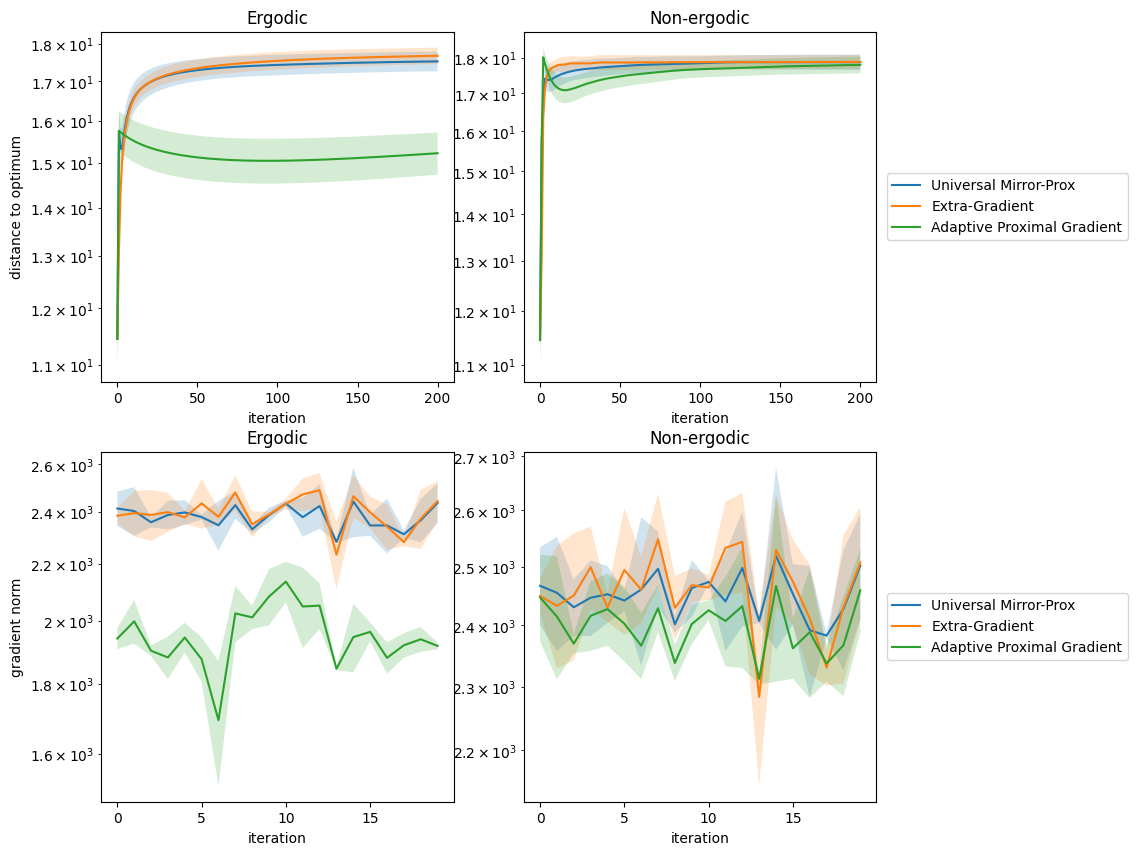

In [899]:
n_trials = 20

_, axs = plt.subplots(2, 2, figsize=(2*5, 2*5))

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=True, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Ergodic', ax=axs[0,0])
pb.plot_trials(trials_by_algo, 'grad_norm', title='Ergodic', ax=axs[1,0])

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=False, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Non-ergodic', ax=axs[0,1], show_legend=True, show_metric_title=False)
pb.plot_trials(trials_by_algo, 'grad_norm', title='Non-ergodic', ax=axs[1,1], show_legend=True, show_metric_title=False)

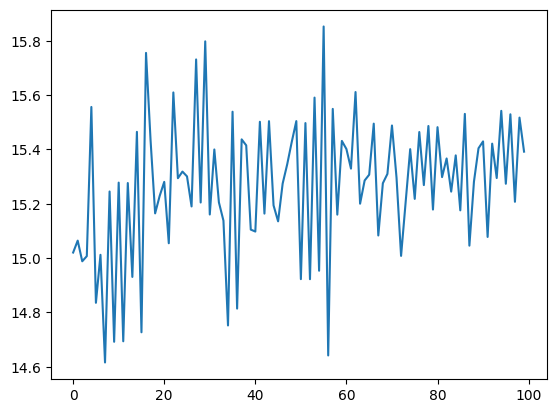

In [900]:
import torch as th

bound = 1
dim = 100

p1_opt_th, p2_opt_th = th.from_numpy(p1_opt), th.from_numpy(p2_opt)
opt_th = th.stack([p1_opt_th, p2_opt_th])
A_th = th.from_numpy(A)

def fx(x):
    return (x[0,:]-p1_opt_th) @ A_th @ (x[1,:]-p2_opt_th)
def proj(x, grad): return th.clamp(x + grad, -bound, bound)

p1 = th.randn(dim, requires_grad=True)
p2 = th.randn(dim, requires_grad=True)


opt_p1 = th.optim.Adam([p1], lr=.1)
opt_p2 = th.optim.Adam([p2], lr=.1)

dist_list = []

for i in range(100):
    opt_p1.zero_grad()
    loss = fx(th.stack([p1, p2]))
    loss.backward()
    opt_p1.step()

    p1.data = proj(p1.data, p1.grad)

    opt_p2.zero_grad()
    loss = -fx(th.stack([p1, p2]))
    loss.backward()
    opt_p2.step()

    p2.data = proj(p2.data, p2.grad)

    x = th.stack([p1, p2])
    dist_list.append((x - opt_th).norm().item())

plt.plot(dist_list)

# Rock-Paper-Scissors

[[1.  0. ]
 [0.  0.5]]


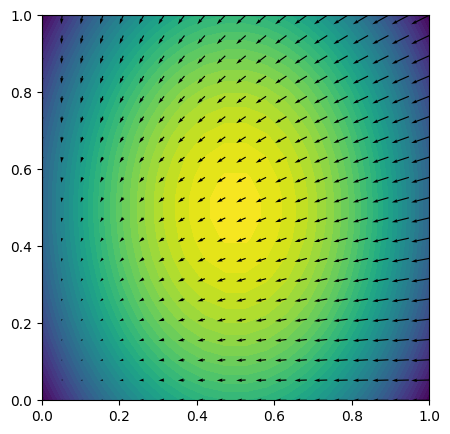

In [1011]:
dim = 2

# for d=3
#    R  P  S
# R [0, -1, 1],
# P [1, 0, -1],
# S [-1, 1, 0],
# A = np.zeros((dim, dim)) - np.roll(np.eye(dim), -1, axis=0) + np.roll(np.eye(dim), 1, axis=0)
# A = np.zeros((dim, dim)) - np.r_[np.eye(dim)[1:], np.zeros((1,dim))] + np.r_[np.zeros((1,dim)), np.eye(dim)[:-1]]

A = np.array([
    [1, 0],
    [0, 1/2]
])

print(A)

def simplex_proj(y):
    # from https://arxiv.org/pdf/1309.1541.pdf
    u = -np.sort(-y)
    j = np.arange(1, len(y)+1)
    cumsum_u = np.cumsum(u)
    rho = y + 1/j * (1 - cumsum_u)
    rho = np.max(np.where(rho > 0)[0])
    lbd = 1/(rho+1) * (1 - cumsum_u[rho])
    return np.maximum(y + lbd, 0)

def fx(x): return (x[...,0,:] @ A @ x[...,1,:].T).diagonal()
def dfx(x): return np.stack([x[...,1,:] @ A.T, -x[...,0,:] @ A], axis=0)
def proj(x, grad):
    x = x + grad
    x[0,:] = simplex_proj(x[0,:])
    x[1,:] = simplex_proj(x[1,:])
    return x

default_run_args = {
    'n': 200,
    'init_space': [0, 1],
    'seed': 41,
    'eta': .1,
}

pb = Problem(fx, dfx, proj, dim=(2, dim))

def plot_fx(ax=None):
    if dim != 2:
        print('Cannot plot for dim != 2')
        return

    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    space = np.linspace(*default_run_args['init_space'], 20)
    X1_a1, X2_a1 = np.meshgrid(space, space)
    X1_a2, X2_a2 = 1-X1_a1, 1-X2_a1
    X1, X2 = np.stack([X1_a1, X1_a2], axis=-1), np.stack([X2_a1, X2_a2], axis=-1)
    X = np.stack([X1, X2], axis=-1)
    Y = fx(X.reshape(-1, 2, 2)).reshape(X1_a1.shape)
    x = X.reshape(-1, 2, 2)
    # print(x.shape, dfx(x).shape)

    c = ax.contourf(X1_a1, X2_a1, Y, 40)
    ax.quiver(X1_a1.flatten(), X2_a1.flatten(), *dfx(x)[1].T, color='k')
    # ax.scatter(*opt, marker='x', color='k')

plot_fx()

trials ({'ergodic': False, 'eta': 0.1}): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


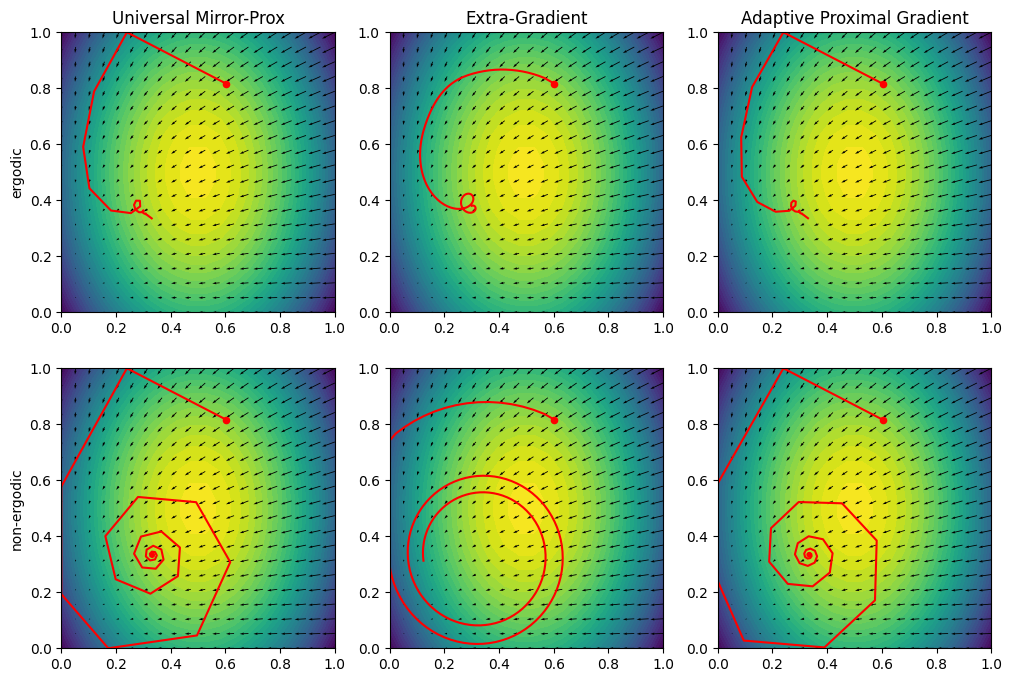

In [1012]:
n_plots = len(algos)
_, axs = plt.subplots(2, n_plots, figsize=(4*n_plots, 4*2))

for i, ergodic in enumerate([True, False]):
    trials_by_algo = pb.run_trials(n_trials=1, ergodic=ergodic,
    **default_run_args)

    axs[i, 0].set_ylabel('ergodic' if ergodic else 'non-ergodic')
    for j, (algo, trials) in enumerate(trials_by_algo.items()):
        trial = trials[0]
        plot_fx(ax=axs[i, j])
        axs[i,j].plot(trial[:,0,0], trial[:,1,0], '-', color='r')
        axs[i,j].scatter(*trial[0,:,0], color='r', s=20)
        if i == 0:
            axs[i,j].set_title(algo)

np.diag([1,1])[:-1].

In [1009]:
trials_by_algo = pb.run_trials(n_trials=1, ergodic=True, **default_run_args)

for algo, trials in trials_by_algo.items():
    trial = trials[0]
    print(algo, trial[-1])

trials ({'ergodic': True, 'eta': 0.1}): 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]

Universal Mirror-Prox [[0.33178419 0.66821581]
 [0.33251542 0.66748458]]
Extra-Gradient [[0.30791755 0.69208245]
 [0.32694955 0.67305045]]
Adaptive Proximal Gradient [[0.33164506 0.66835494]
 [0.33245481 0.66754519]]


trials ({'ergodic': True, 'eta': 0.1}): 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


No optimum provided, skipping distance to optimum plot
No optimum provided, skipping distance to optimum plot
No optimum provided, skipping distance to optimum plot


trials ({'ergodic': False, 'eta': 0.1}): 100%|██████████| 20/20 [00:00<00:00, 23.92it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No optimum provided, skipping distance to optimum plot
No optimum provided, skipping distance to optimum plot
No optimum provided, skipping distance to optimum plot


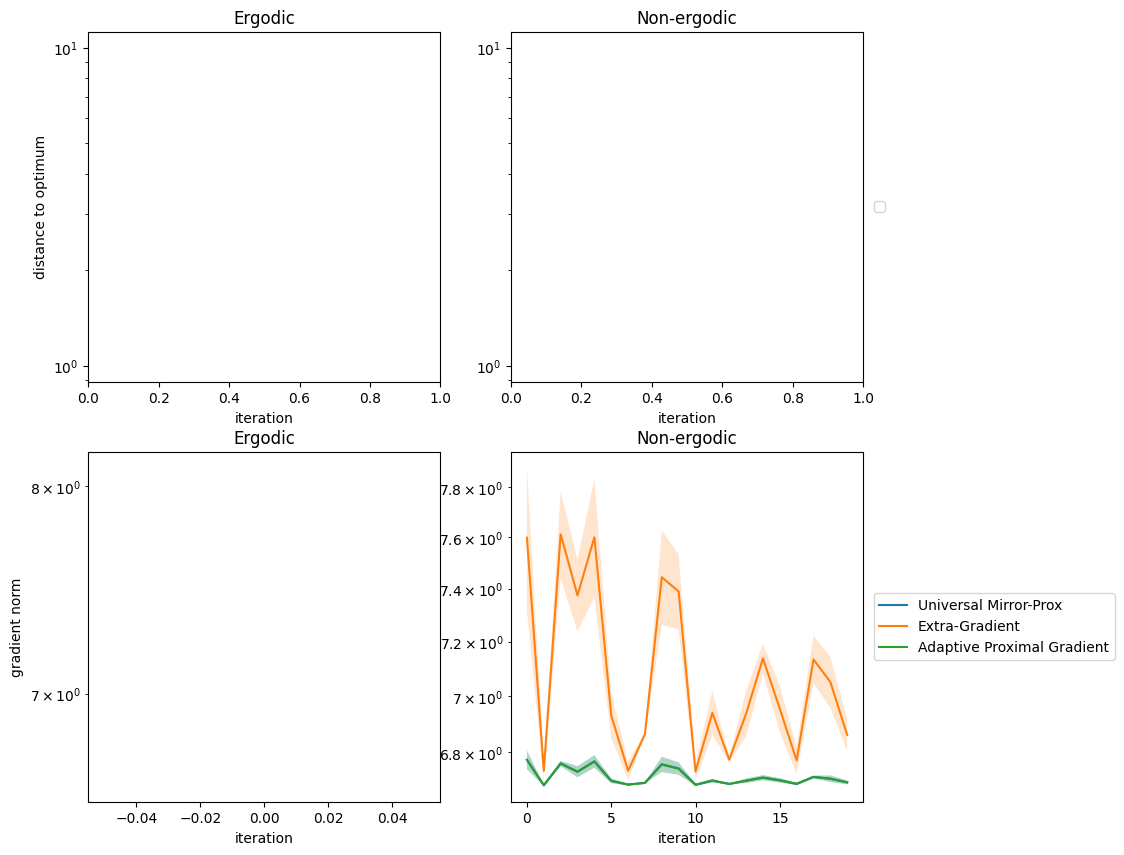

In [1013]:
n_trials = 20

_, axs = plt.subplots(2, 2, figsize=(2*5, 2*5))

trials_by_algo = pb.run_trials(n_trials=1, ergodic=True, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Ergodic', ax=axs[0,0])
pb.plot_trials(trials_by_algo, 'grad_norm', title='Ergodic', ax=axs[1,0])

trials_by_algo = pb.run_trials(n_trials=n_trials, ergodic=False, **default_run_args)
pb.plot_trials(trials_by_algo, 'opt_dist', title='Non-ergodic', ax=axs[0,1], show_legend=True, show_metric_title=False)
pb.plot_trials(trials_by_algo, 'grad_norm', title='Non-ergodic', ax=axs[1,1], show_legend=True, show_metric_title=False)

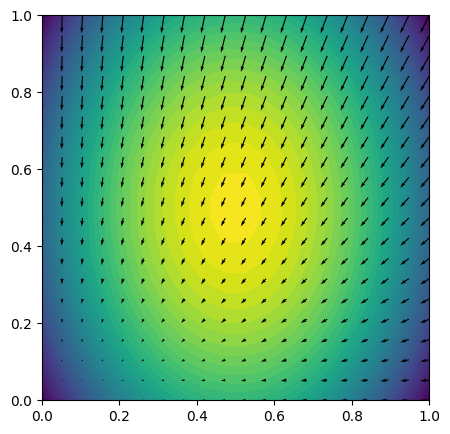

In [1014]:
dim = 2

# for d=3
#    R  P  S
# R [0, -1, 1],
# P [1, 0, -1],
# S [-1, 1, 0],
# A = np.zeros((dim, dim)) - np.roll(np.eye(dim), -1, axis=0) + np.roll(np.eye(dim), 1, axis=0)
# A = np.zeros((dim, dim)) - np.r_[np.eye(dim)[1:], np.zeros((1,dim))] + np.r_[np.zeros((1,dim)), np.eye(dim)[:-1]]

A1 = np.array([
    [2, 0],
    [0, 1]
])
A2 = np.array([
    [1, 0],
    [0, 2]
])

def simplex_proj(y):
    # from https://arxiv.org/pdf/1309.1541.pdf
    u = -np.sort(-y)
    j = np.arange(1, len(y)+1)
    cumsum_u = np.cumsum(u)
    rho = y + 1/j * (1 - cumsum_u)
    rho = np.max(np.where(rho > 0)[0])
    lbd = 1/(rho+1) * (1 - cumsum_u[rho])
    return np.maximum(y + lbd, 0)

def fx(x): return (x[...,0,:] @ A1 @ x[...,1,:].T).diagonal()
def dfx(x): return np.stack([x[...,1,:] @ A1.T, -x[...,0,:] @ A2], axis=0)
def proj(x, grad):
    x = x + grad
    x[0,:] = simplex_proj(x[0,:])
    x[1,:] = simplex_proj(x[1,:])
    return x

default_run_args = {
    'n': 200,
    'init_space': [0, 1],
    'seed': 42,
    'eta': .1,
}

pb = Problem(fx, dfx, proj, dim=(2, dim))

def plot_fx(ax=None):
    if dim != 2:
        print('Cannot plot for dim != 2')
        return

    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    space = np.linspace(*default_run_args['init_space'], 20)
    X1_a1, X2_a1 = np.meshgrid(space, space)
    X1_a2, X2_a2 = 1-X1_a1, 1-X2_a1
    X1, X2 = np.stack([X1_a1, X1_a2], axis=-1), np.stack([X2_a1, X2_a2], axis=-1)
    X = np.stack([X1, X2], axis=-1)
    Y = fx(X.reshape(-1, 2, 2)).reshape(X1_a1.shape)
    x = X.reshape(-1, 2, 2)
    # print(x.shape, dfx(x).shape)

    c = ax.contourf(X1_a1, X2_a1, Y, 40)
    ax.quiver(X1_a1.flatten(), X2_a1.flatten(), *dfx(x)[1].T, color='k')
    # ax.scatter(*opt, marker='x', color='k')

plot_fx()

trials ({'ergodic': False, 'eta': 0.1}): 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


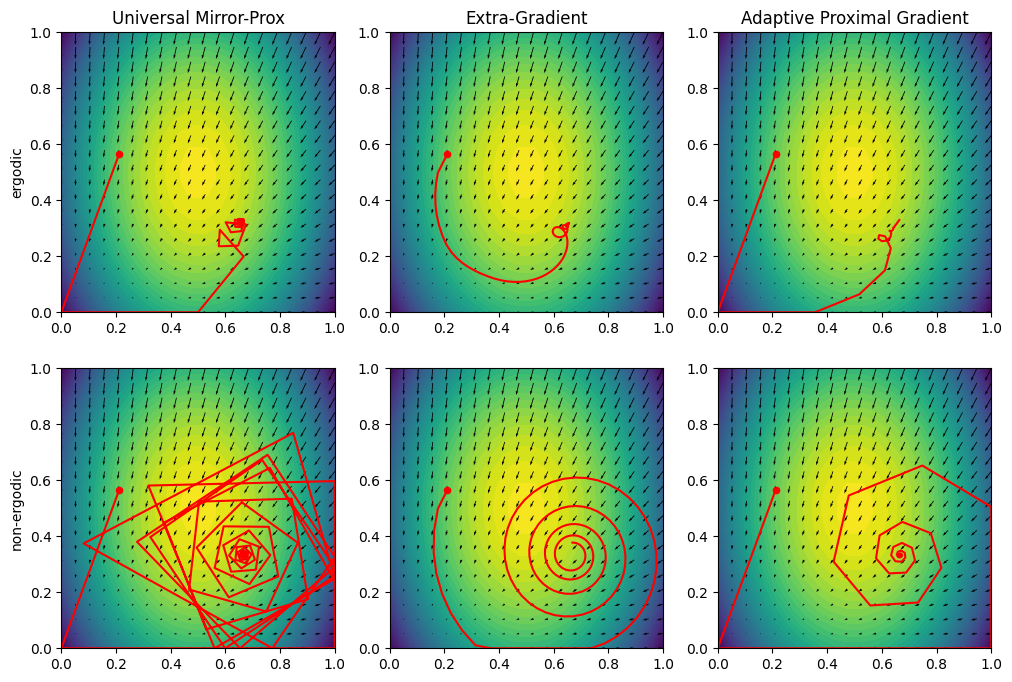

In [1015]:
n_plots = len(algos)
_, axs = plt.subplots(2, n_plots, figsize=(4*n_plots, 4*2))

for i, ergodic in enumerate([True, False]):
    trials_by_algo = pb.run_trials(n_trials=1, ergodic=ergodic,
    **default_run_args)

    axs[i, 0].set_ylabel('ergodic' if ergodic else 'non-ergodic')
    for j, (algo, trials) in enumerate(trials_by_algo.items()):
        trial = trials[0]
        plot_fx(ax=axs[i, j])
        axs[i,j].plot(trial[:,0,0], trial[:,1,0], '-', color='r')
        axs[i,j].scatter(*trial[0,:,0], color='r', s=20)
        if i == 0:
            axs[i,j].set_title(algo)